In [1]:
import glob
from io import open
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import spacy
import string
import time
import torch
import torch.nn as nn
import unicodedata

In [2]:
# Utility functions

def flat_map(f, xs):
    result = []
    for x in xs:
        result.extend(f(x))
    return result

# `weights` is an array of weights to be sampled
def weighted_sample(weights):
    total_weight = sum(weights)
    choice = random.randint(1, total_weight)
    running_weight = 0
    for idx, w in enumerate(weights):
        running_weight += w
        if running_weight >= choice:
            return idx
        
spacy_en = spacy.load('en_core_web_sm')
def tokenize_line(string):
    # remove underscores and asterisks (used to denote emphasis in some transcriptions)
    string = string.replace('_', '')
    string = string.replace('*', '')
    
    string = string.replace('--', ' -- ')
    string = string.replace(':', ' : ')
    
    tokens = [tok.text.lower() for tok in spacy_en.tokenizer(string)]
    
    # filter out all-whitespace tokens
    tokens = [tok for tok in tokens if not re.match('^\s+$', tok)]
    
    return tokens

def average(xs): return sum(xs)/len(xs)

In [11]:
# A single literary work, represented as a list of tokens
class Work:
    def __init__(self, author, tokens, title):
        self.author = author
        self.tokens = tokens
        self.title = title
    
    def random_passage(self, glove: GloVe, length):
        while True:
            start = random.randint(0, len(self.tokens) - length)
            end = start + length
            result = self.tokens[start:end]
            
            # only return passages where all words are within the word embedding's vocab
            valid = True
            for tok in result:
                if not glove.has_word(tok):
                    valid = False
                    break
            if not valid:
                continue
                
            return result

# The full dataset of all literary works.
class Dataset:
    DATASET_GLOBS = [
        # A smaller collection of 5 works, used for debugging the model
#         'gutenberg/Charles Dickens___A C*',
#         'gutenberg/Mark Twain___A D*'
        
        # All works by Dickens and Twain.
        'gutenberg/*.txt'
    ]
    
    def __init__(self):
        self.author_to_idx = {}
        self.next_author_idx = 0
        self.works = []

        for dataset_glob in self.DATASET_GLOBS:
            for path in glob.glob(dataset_glob):
                [author, title] = os.path.basename(path).split('___')
                tokens = self.read_tokens(path)
                self.add_work(Work(author, tokens, title))
                
        self.num_authors = self.next_author_idx
                
    def read_tokens(self, path):
        lines = open(path, encoding='utf-8').read().strip().split('\n')
        tokens = flat_map(tokenize_line, lines)
        return tokens
    
    def add_work(self, work):
        if work.author not in self.author_to_idx:
            self.author_to_idx[work.author] = self.next_author_idx
            self.next_author_idx += 1
        self.works.append(work)
        
    def works_by_author(self, author_idx):
        return [work for work in self.works
                     if self.author_to_idx[work.author] == author_idx]
        
    # returns random passages written by the author given by `author_idx`
    def random_passages(self, glove: GloVe, author_idx, passage_len, quantity):
        author_works = [work for work in self.works 
                             if self.author_to_idx[work.author] == author_idx]
        work_weights = [len(work.tokens) for work in author_works]
        
        passages = []
        while len(passages) < quantity:
            work_idx = weighted_sample(work_weights)
            passages.append(author_works[work_idx].random_passage(glove, passage_len))
        
        return passages
    
    def training_dataset(self, glove: GloVe, passage_len, passages_per_author):
        return [(passage, author_idx) for author_idx in range(self.num_authors)
                                      for passage in self.random_passages(glove, author_idx, passage_len, passages_per_author)]
    
    def unknown_tokens(self, glove: GloVe):
        result = set()
        
        for work in self.works:
            for token in work.tokens:
                if not glove.has_word(token):
                    result.add(token)
                    
        return result

In [5]:
class GloVe:
    paths = {
        "sample": "glove/glove.sample.txt",
        "6B.50d": "glove/glove.6B.50d.txt",
        "6B.300d": "glove/glove.6B.300d.txt",
        "42B.300d": "glove/glove.42B.300d.txt",
    }
    
    def __init__(self, path):
        self.path = path
        self.word_to_idx = {}
        self.idx_to_word = []
        vectors = []
        idx = 0
        
        with open(path, 'rb') as file:
            for line in file:
                line = line.decode().split()
                word = line[0]
                self.word_to_idx[word] = idx
                self.idx_to_word.append(word)
                idx += 1
                vectors.append(torch.from_numpy(np.array(line[1:]).astype(np.float)).to(torch.float))
            self.vectors = torch.stack(vectors, dim=0)
        
        self.dim = vectors[0].shape[0]
                
    def has_word(self, word):
        return word in self.word_to_idx
    
    def get_word_idx(self, word):
        return self.word_to_idx[word]
    
    def get_word_vector(self, word):
        return self.vectors[self.word_to_idx[word]]
    
    # embed a 2-dimensional batched input into the given glove embedding
    def embed_token_batch(self, batch):
        result = []
        for passage in batch:
            embed = ()
            for word in passage:
                if self.has_word(word):
                    embed += (self.word_to_idx[word],)
                else:
                    # Shouldn't happen, since we're only using passages that
                    # stay within the embedding's vocabulary. 
                    # This is left in as an error message
                    print('unknown word: ' + word)
            result.append(embed)
        return torch.tensor(result)

In [7]:
# save a global reference to a glove word embedding

global_glove_42B = GloVe(GloVe.paths['42B.300d'])
global_glove_6B_50d = GloVe(GloVe.paths['6B.50d'])

In [37]:
# Solve an analogy w1:w2::w3:w4 for w4 as a demonstration of the GloVe embedding.
# This is otherwise unrelated to the project's main objective.
def solve_analogy(glove: GloVe, w1, w2, w3):
    v1 = glove.get_word_vector(w1)
    v2 = glove.get_word_vector(w2)
    v3 = glove.get_word_vector(w3)
    v_target = v2 - v1 + v3
    result = None
    min_dist = None
    
    for i, v in enumerate(glove.vectors):
        w = glove.idx_to_word[i]
        # only search the most commonly used 100000 words
        if i >= 100000:
            break
        v_dist = torch.norm(v - v_target, 2)
        if min_dist == None or v_dist < min_dist:
            result = w
            min_dist = v_dist
            
    return result

# Solve the following analogy for 'japan' using the glove embedding:
# Beijing : China :: Tokyo : Japan
# solve_analogy(global_glove_42B, 'beijing', 'china', 'tokyo')

In [38]:
# The RNN used for authorship identification.
# It is parameterized by the size of its hidden layer, as well as
# the number of authors it is classifying (which determines its output size).
class RNNAuthorship(nn.Module):
    def __init__(self, glove: GloVe, num_authors: int, hidden_size: int):
        super(RNNAuthorship, self).__init__()
        
        self.hidden_size = hidden_size
        self.glove = glove
        
        self.embedding = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = int(glove.dim  * 1.5)
        self.rnn = nn.RNN(input_size=glove.dim, hidden_size=self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, num_authors)
    
    # defines the initial values of the hidden layer
    # here, we initialize the hidden layer to a tensor of all zeros
    def init_hidden(self, x):
        return torch.zeros(1, x.size(1), self.hidden_size)
    
    def forward(self, passage):
        x = glove.embed_token_batch(passage)
        x = self.embedding(x)
        x, _ = self.rnn(x, self.init_hidden(x))
        # extract the last layer of time-indexed values,
        # corresponding to the final output of the model
        x = self.fc(x[-1, :, :])
        return x

In [82]:
class Hyperparameters:
    def __init__(self, glove, dataset, hidden_size, learning_rate):
        self.glove = glove
        self.dataset = dataset
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
class ExpResults:
    def __init__(self, hps, train_losses, test_accs, duration):
        self.hps = hps
        self.train_losses = train_losses
        self.test_accs = test_accs
        self.duration = duration
        
    def plot(self):
        epochs, epochs_per_iter = Experiment.epochs, Experiment.epochs_per_iteration
        train_losses, test_accs = self.train_losses, self.test_accs
        
        epoch_ticks = range(epochs_per_iter, epochs + 1, epochs_per_iter)
        if len(epoch_ticks) > 10:
            epoch_ticks = epoch_ticks[::len(epoch_ticks)/10]
        
        # plot training loss
        plt.plot(range(1, epochs + 1), train_losses)
        plt.xticks(epoch_ticks)
        plt.xlabel('Epochs trained')
        plt.ylabel('Training loss')
        plt.show()
        
        # plot testing accuracy
        plt.plot(epoch_ticks, test_accs)
        plt.xticks(epoch_ticks)
        plt.xlabel('Epochs trained')
        plt.ylabel('Testing accuracy')
        plt.show()

class Experiment:
    # hyperparameters determining the scale of the experiments.
    # these will be the same for all experiments.
    train_passages_per_author = 40000
    test_passages_per_author = 10000
    
    epochs_per_iteration = 10
    iterations = 10
    epochs = epochs_per_iteration * iterations
    
    def __init__(self, hps: Hyperparameters):
        self.hps = hps
        self.dataset = hps.dataset
        self.glove = hps.glove
        self.rnn = RNNAuthorship(self.glove, self.dataset.num_authors, hps.hidden_size)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.rnn.parameters(), lr=hps.learning_rate)
        self.epochs_trained = 0
    
    def train(self, training_dataset, epochs):
        dataset, criterion, optimizer, rnn = self.dataset, self.criterion, self.optimizer, self.rnn
        train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=30, shuffle=True)
        losses = []
        
        for epoch in range(epochs):
            epoch_loss = 0
            batches = 0
            step = 0
            for passages, labels in train_loader:
                optimizer.zero_grad()
                pred = rnn(passages)
                loss = criterion(pred, labels)
                epoch_loss += loss.item()
                batches += 1
                loss.backward()
                optimizer.step()
            self.epochs_trained += 1
            losses.append(epoch_loss/batches)
        
        # print(f'{epochs} epochs trained. Loss = {average(losses)}')
        return losses
    
    def test(self, testing_dataset):
        rnn, glove = self.rnn, self.glove
        test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=10)
        correct, total = 0, 0
        for passages, labels in test_loader:
            output = rnn(passages)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += labels.shape[0]
        # print(f'Test accuracy: {correct}/{total} correct ({float(correct)/total*100:.2f}%)')
        return correct / total
    
    def run_experiment(self, passage_len):
        epochs_per_iteration, iterations, epochs = self.epochs_per_iteration, self.iterations, self.epochs
        train_passages_per_author, test_passages_per_author = self.train_passages_per_author, self.test_passages_per_author
        
        training_dataset = self.dataset.training_dataset(self.glove, passage_len, train_passages_per_author)
        testing_dataset = self.dataset.training_dataset(self.glove, passage_len, test_passages_per_author)
        train_losses = []
        test_accs = []
        
        # run timed training/testing cycle
        start_time = time.perf_counter()
        
        for i in range(iterations):
            next_losses = self.train(training_dataset, epochs_per_iteration)
            train_losses += next_losses
            
            next_acc = self.test(testing_dataset)
            test_accs.append(next_acc)
            print(f'Iteration {i} complete. Test accuracy={next_acc:.5f}')
        
        duration = time.perf_counter() - start_time
        
        return ExpResults(self.hps, train_losses, test_accs, duration)

In [12]:
# The dataset consisting of works by Dickens and Twain.
# (i.e. there are two authors being identified in this experiment)
dataset = Dataset()

In [15]:
# Get a sample of words used in the literature corpus that aren't present
# in the word embedding vocabulary.

unk_tokens = dataset.unknown_tokens(global_glove_42B)

In [28]:
unk_tokens = list(unk_tokens)
len(unk_tokens)
unk_tokens.sort()
unk_tokens[12000:]

['wisitation',
 'wisitations',
 'wisited',
 'wisitin',
 'wisiting',
 'wisitors',
 'wisits',
 'wisperin',
 'wistlers',
 'wital',
 'witch-',
 'witchem',
 'witcheries',
 'witchingest',
 'with,—and',
 "wither'd",
 'witherfield',
 'witherosever',
 'within\x97joan',
 'with\x97ah',
 'with—‘please',
 'wititterly',
 'wititterlys',
 'witler',
 "wits'-end",
 'wittemberg',
 'wiwid',
 'wixin',
 'wlgw',
 "woan't",
 'wobblehorn',
 'wocalist',
 'wohlan',
 'wohlmeyer',
 'woices',
 "wolf's",
 'wollatilly',
 'wolloston',
 'wolloway',
 'wollume',
 'wollumes',
 'wolsy',
 'wolunteering',
 'wolunteers',
 'womanfold',
 'woman\x97no',
 'woman’s',
 'woman’—‘accustomed',
 'wombed',
 "won't",
 "won't.",
 'wondar',
 'wonderfulest',
 'won’t',
 'won’t!’—‘you',
 "woo'd",
 'woobad',
 'wood-',
 'woodboats',
 'woodcot',
 'woodenest',
 'woodensconce',
 'woodenshod',
 'woodent',
 'woodeny',
 'woodyards',
 'woolloomoolloo',
 'woolundunga',
 'woonder',
 'woostershyre',
 'word!—well',
 'wordses',
 'words—‘it',
 'words—‘the',

In [12]:
# Compute the token counts for Dickens and Twain works, respectively.
token_counts = [[len(work.tokens) for work in dataset.works_by_author(author_idx)]
                for author, author_idx in dataset.author_to_idx.items()]
token_counts = [sum(author_counts) for author_counts in token_counts]
token_counts

[7106531, 3362610]

In [77]:
# Run initial round of experiments for hyperparameter tuning.

all_exp_results = []

all_glove = [global_glove_6B_50d, global_glove_42B]
all_hidden_size = [25, 50, 100]
all_learning_rate = [0.0005, 0.001, 0.005]

for glove in all_glove:
    for hidden_size in all_hidden_size:
        for lr in all_learning_rate:
            hps = Hyperparameters(glove, dataset, hidden_size, lr)
            exp = Experiment(hps)
            
            exp_results = exp.run_experiment(passage_len=30)
            all_exp_results.append(exp_results)



glove=glove/glove.6B.50d.txt, hidden_size=25, lr=0.0005
duration:  1388.0484421
final training loss:  0.4837066041348264
final test acc:  0.7586
best test acc:  0.7597


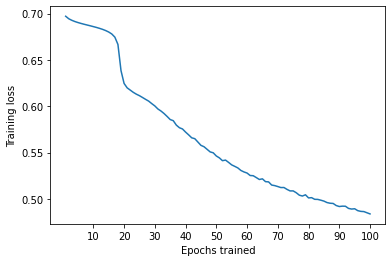

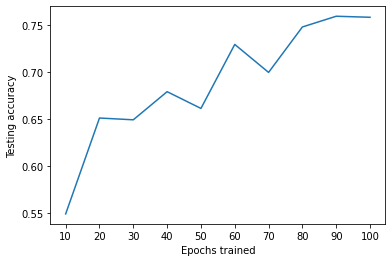

glove=glove/glove.6B.50d.txt, hidden_size=25, lr=0.001
duration:  1415.5405662000012
final training loss:  0.4553175350846
final test acc:  0.7854
best test acc:  0.7854


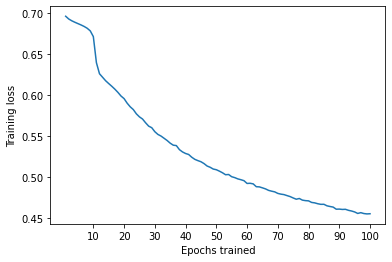

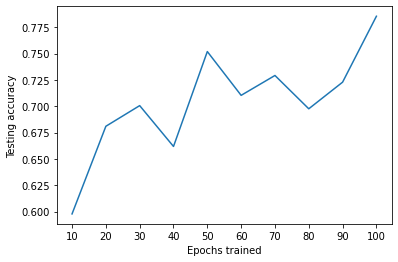

glove=glove/glove.6B.50d.txt, hidden_size=25, lr=0.005
duration:  1384.7574821000017
final training loss:  0.40389988893509626
final test acc:  0.79715
best test acc:  0.79715


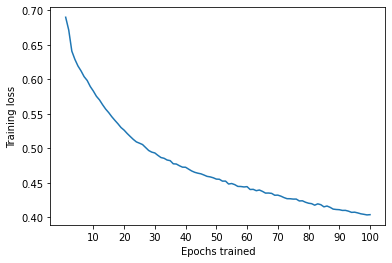

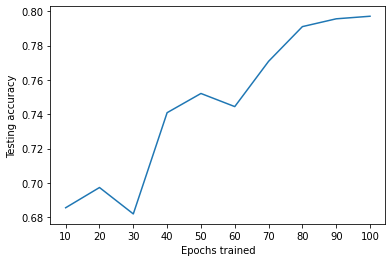

glove=glove/glove.6B.50d.txt, hidden_size=50, lr=0.0005
duration:  1404.7693258
final training loss:  0.4832378306894388
final test acc:  0.66395
best test acc:  0.7583


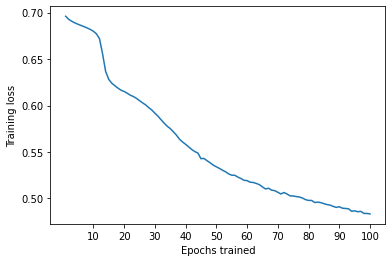

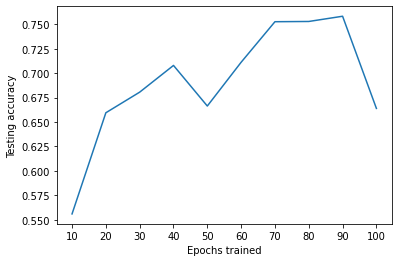

glove=glove/glove.6B.50d.txt, hidden_size=50, lr=0.001
duration:  1432.677312599997
final training loss:  0.4584954630068102
final test acc:  0.7809
best test acc:  0.7809


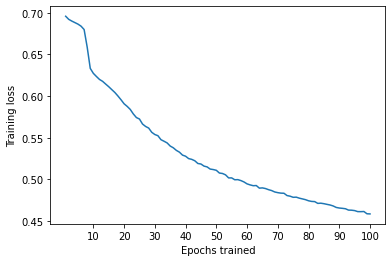

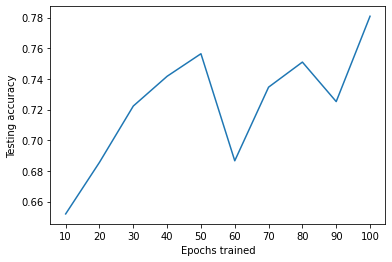

glove=glove/glove.6B.50d.txt, hidden_size=50, lr=0.005
duration:  1441.6892989999978
final training loss:  0.4079522779361559
final test acc:  0.79555
best test acc:  0.79555


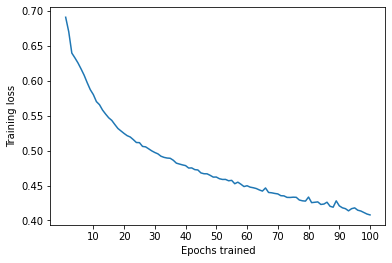

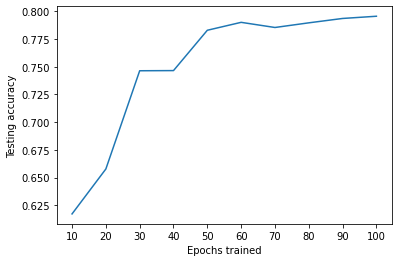

glove=glove/glove.6B.50d.txt, hidden_size=100, lr=0.0005
duration:  1219.6306081000002
final training loss:  0.47410400809086706
final test acc:  0.7631
best test acc:  0.7631


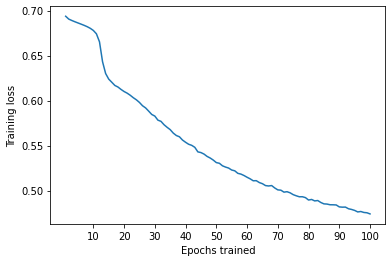

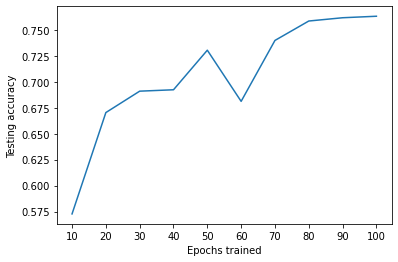

glove=glove/glove.6B.50d.txt, hidden_size=100, lr=0.001
duration:  1184.6075734000005
final training loss:  0.4541281539322421
final test acc:  0.78965
best test acc:  0.78965


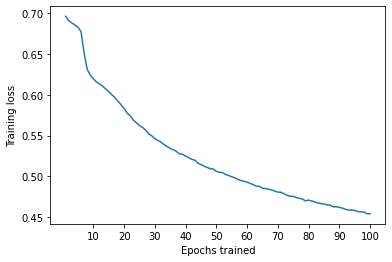

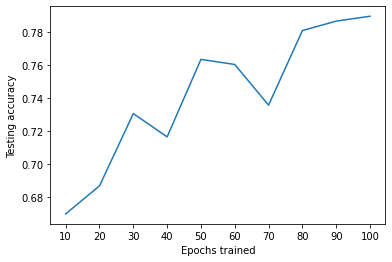

glove=glove/glove.6B.50d.txt, hidden_size=100, lr=0.005
duration:  1181.6876054999993
final training loss:  0.4146003944063884
final test acc:  0.79415
best test acc:  0.7947


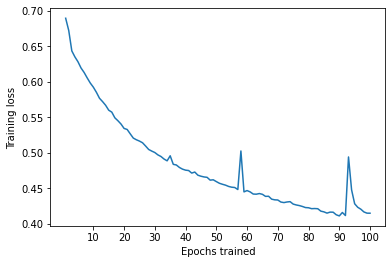

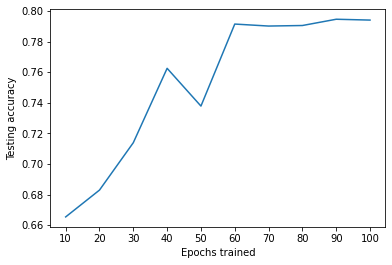

glove=glove/glove.42B.300d.txt, hidden_size=25, lr=0.0005
duration:  4710.200806200002
final training loss:  0.4321669338178134
final test acc:  0.7813
best test acc:  0.7966


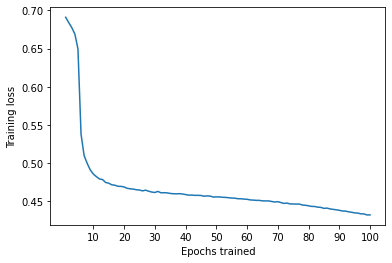

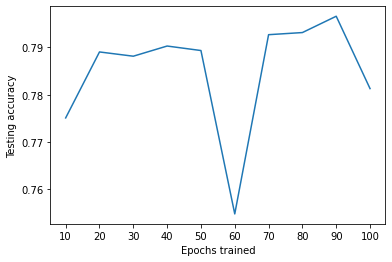

glove=glove/glove.42B.300d.txt, hidden_size=25, lr=0.001
duration:  5191.276014800002
final training loss:  0.3732861228535852
final test acc:  0.7766
best test acc:  0.8036


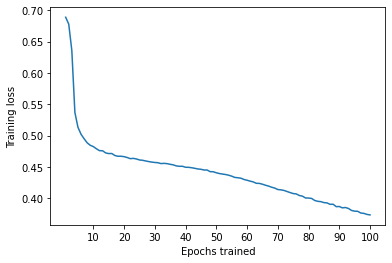

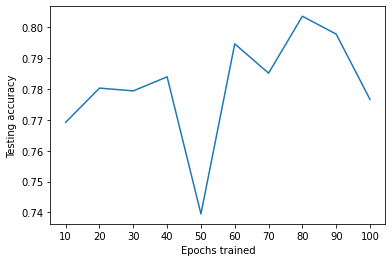

glove=glove/glove.42B.300d.txt, hidden_size=25, lr=0.005
duration:  5320.4850678
final training loss:  0.14426083550908936
final test acc:  0.784
best test acc:  0.80745


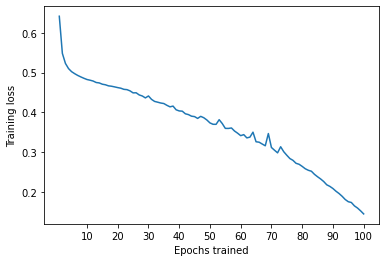

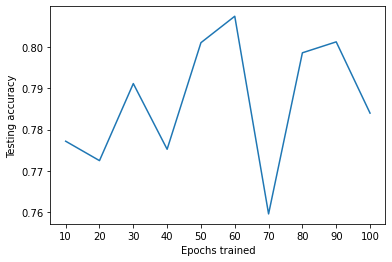

In [76]:
for results in all_exp_results:
    print_hps(results.hps)
    print('duration: ', results.duration)
    print('final training loss: ', results.train_losses[-1])
    print('final test acc: ', results.test_accs[-1])
    print('best test acc: ', max(results.test_accs))
    results.plot()

In [72]:
def print_hps(hps):
    print(f'glove={hps.glove.path}, hidden_size={hps.hidden_size}, lr={hps.learning_rate}')

glove=glove/glove.42B.300d.txt, hidden_size=50, lr=0.0005
duration:  5438.675977300001
final training loss:  0.42804718456176233
final test acc:  0.79895
best test acc:  0.79895


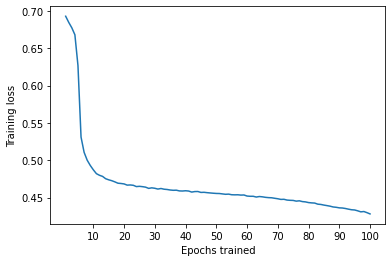

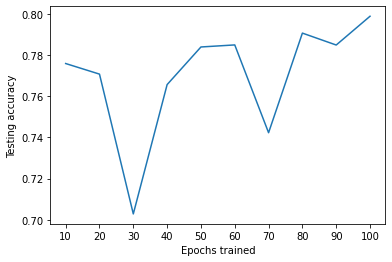

glove=glove/glove.42B.300d.txt, hidden_size=50, lr=0.001
duration:  5331.501362200004
final training loss:  0.3638804450849044
final test acc:  0.79285
best test acc:  0.8194


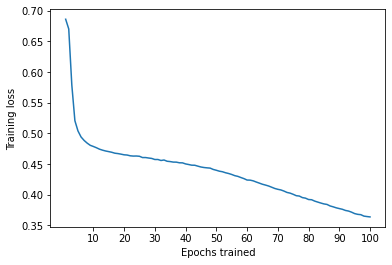

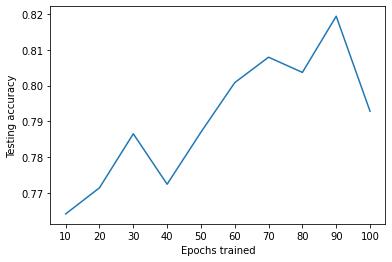

glove=glove/glove.42B.300d.txt, hidden_size=50, lr=0.005
duration:  4783.552331699997
final training loss:  0.13085935045107724
final test acc:  0.78095
best test acc:  0.79665


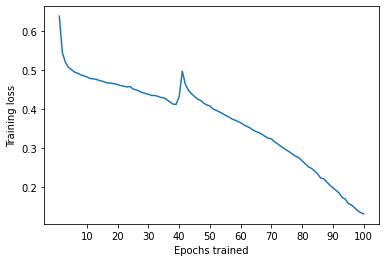

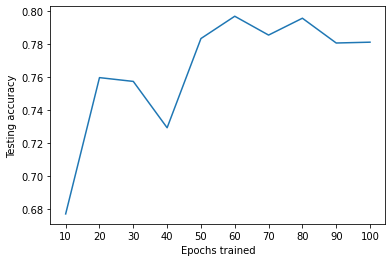

glove=glove/glove.42B.300d.txt, hidden_size=100, lr=0.0005
duration:  4779.597613999998
final training loss:  0.4244947164166854
final test acc:  0.7876
best test acc:  0.7959


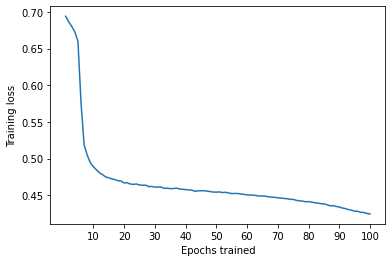

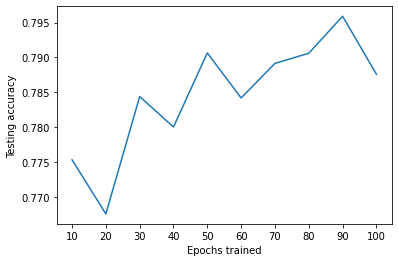

glove=glove/glove.42B.300d.txt, hidden_size=100, lr=0.001
duration:  4739.602211799996
final training loss:  0.37175083022116273
final test acc:  0.8067
best test acc:  0.80825


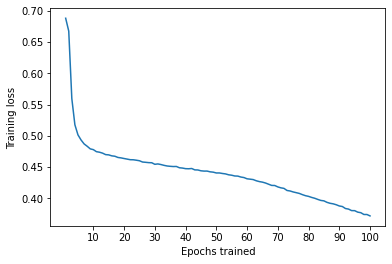

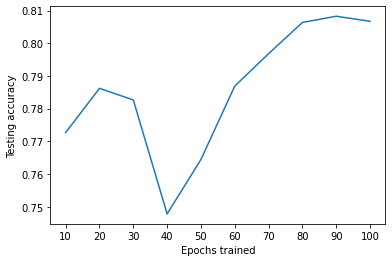

glove=glove/glove.42B.300d.txt, hidden_size=100, lr=0.005
duration:  4700.5849514
final training loss:  0.13064953783875521
final test acc:  0.79485
best test acc:  0.8129


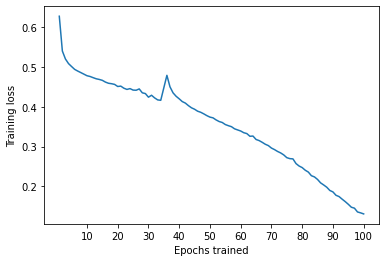

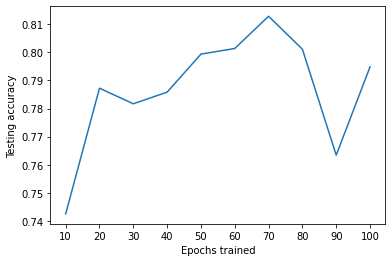

In [78]:
for results in all_exp_results:
    print_hps(results.hps)
    print('duration: ', results.duration)
    print('final training loss: ', results.train_losses[-1])
    print('final test acc: ', results.test_accs[-1])
    print('best test acc: ', max(results.test_accs))
    results.plot()

In [80]:
# Use the two strongest hyperparameter configurations in a 
# second, longer round of experiments.

Experiment.iterations = 30
Experiment.epochs = Experiment.iterations * Experiment.epochs_per_iteration

all_exp_results_round2 = []

all_glove_round2 = [global_glove_42B]
all_hidden_size_round2 = [50, 100]
all_learning_rate_round2 = [0.001]

for glove in all_glove_round2:
    for hidden_size in all_hidden_size_round2:
        for lr in all_learning_rate_round2:
            hps = Hyperparameters(glove, dataset, hidden_size, lr)
            exp = Experiment(hps)
            
            exp_results = exp.run_experiment(passage_len=30)
            all_exp_results_round2.append(exp_results)

Iteration 0 complete. Test accuracy=0.77265
Iteration 1 complete. Test accuracy=0.74080
Iteration 2 complete. Test accuracy=0.77545
Iteration 3 complete. Test accuracy=0.77820
Iteration 4 complete. Test accuracy=0.78060
Iteration 5 complete. Test accuracy=0.78530
Iteration 6 complete. Test accuracy=0.79585
Iteration 7 complete. Test accuracy=0.80250
Iteration 8 complete. Test accuracy=0.80860
Iteration 9 complete. Test accuracy=0.81685
Iteration 10 complete. Test accuracy=0.81355
Iteration 11 complete. Test accuracy=0.80735
Iteration 12 complete. Test accuracy=0.78795
Iteration 13 complete. Test accuracy=0.80785
Iteration 14 complete. Test accuracy=0.80755
Iteration 15 complete. Test accuracy=0.82735
Iteration 16 complete. Test accuracy=0.82715
Iteration 17 complete. Test accuracy=0.82885
Iteration 18 complete. Test accuracy=0.82020
Iteration 19 complete. Test accuracy=0.82780
Iteration 20 complete. Test accuracy=0.82190
Iteration 21 complete. Test accuracy=0.82640
Iteration 22 complet

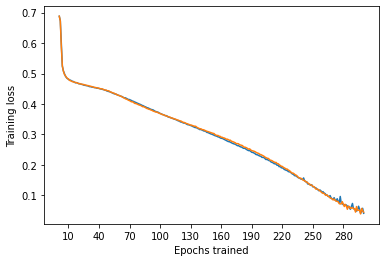

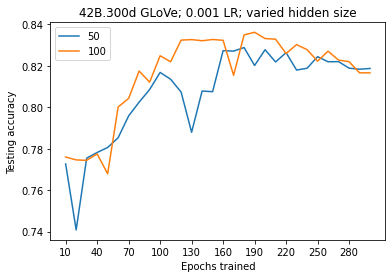

glove=glove/glove.42B.300d.txt, hidden_size=50, lr=0.001
duration:  15823.579221499996
final training loss:  0.04130872220194151
final test acc:  0.81875
peak test acc:  0.82885
peak test acc iteration:  17
glove=glove/glove.42B.300d.txt, hidden_size=100, lr=0.001
duration:  14373.79106979999
final training loss:  0.04504386936431387
final test acc:  0.81665
peak test acc:  0.83625
peak test acc iteration:  18


In [96]:
Experiment.iterations = 30
Experiment.epochs = Experiment.iterations * Experiment.epochs_per_iteration

def plot_exp_round2(exps):
    epochs, epochs_per_iter = Experiment.epochs, Experiment.epochs_per_iteration

    iter_epochs = range(epochs_per_iter, epochs + 1, epochs_per_iter)
    epoch_ticks = iter_epochs
    if len(epoch_ticks) > 10:
        epoch_ticks = epoch_ticks[::int(len(epoch_ticks)/10)]

    # plot training loss
    for exp in exps:
        plt.plot(range(1, epochs + 1), exp.train_losses)
    plt.xticks(epoch_ticks)
    plt.xlabel('Epochs trained')
    plt.ylabel('Training loss')
    plt.show()

    # plot testing accuracy
    for exp in exps:
        plt.plot(iter_epochs, exp.test_accs, label=exp.hps.hidden_size)
    plt.xticks(epoch_ticks)
    plt.xlabel('Epochs trained')
    plt.ylabel('Testing accuracy')
    plt.legend()
    plt.title('42B.300d GLoVe; 0.001 LR; varied hidden size')
    plt.show()
    
plot_exp_round2(all_exp_results_round2)

for results in all_exp_results_round2:
    print_hps(results.hps)
    print('duration: ', results.duration)
    print('final training loss: ', results.train_losses[-1])
    print('final test acc: ', results.test_accs[-1]) 
    print('peak test acc: ', max(results.test_accs))
    print('peak test acc iteration: ', results.test_accs.index(max(results.test_accs)))